In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
%load_ext rpy2.ipython

In [33]:
# Load all the data
dir = "/Users/gustxsr/Documents/Stanford/PoldrackLab/Vagus Nerve and Cognition/eyeNARPS/NARPS_MG_asc_processed"
blink_data, saccade_data = [], []
saccade_rate = []

for file in os.listdir(dir):
    if file.endswith("blink_info.csv"):
        csv = pd.read_csv(os.path.join(dir, file))
        csv['sub'] = int(file[4:7])
        blink_data.append(csv)
    elif file.endswith("saccade_info.csv"):
        csv = pd.read_csv(os.path.join(dir, file))
        csv['sub'] = int(file[4:7])
        saccade_data.append(csv)
    elif file.endswith("saccade_rate.csv"):
        csv = pd.read_csv(os.path.join(dir, file))
        saccade_rate.append(csv)

# Concatenate all the data
blink_data = pd.concat(blink_data)
saccade_data = pd.concat(saccade_data)
saccade_rate = pd.concat(saccade_rate)

# Create blink rate
blink_data["blink_rate"] = blink_data["num_blinks"] / blink_data["duration"] * 1000
# Create saccade rate
saccade_data["sacc_rate"] = saccade_data["num_sacc"] / saccade_data["duration"] * 1000

In [36]:
invalid_subs = saccade_rate.query("rate.isna()")["sub"].unique()

In [38]:
saccade_rate = saccade_rate.query("sub not in @invalid_subs")

<Axes: xlabel='time', ylabel='rate'>

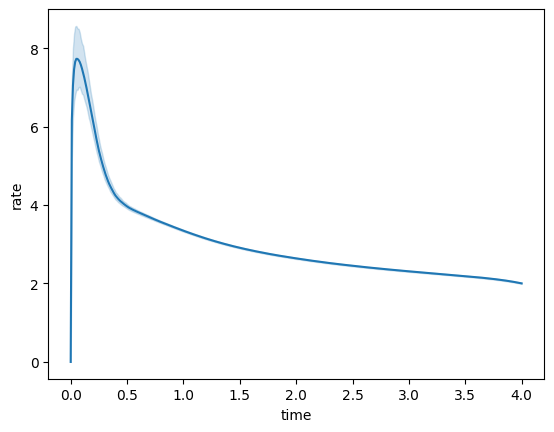

In [39]:
sns.lineplot(saccade_rate, x = "time", y = "rate")

In [3]:
behav = pd.read_csv("/Users/gustxsr/Documents/Stanford/PoldrackLab/github/analysisNARPS/data/narps_behav_data.csv")
trial_id = [i for i in range(1, 257)]*behav['sub'].nunique()
behav['trial'] = trial_id
behav['uncertain'] = behav['response_int'].apply(lambda x: 1 if x == 2 or x == 3 else 0)
behav = behav.loc[:, ~behav.columns.str.contains('^Unnamed')]

# Create column called dist_indiff
behav['dist_from_indiff'] = np.abs(behav['gain'] - behav['loss']) / np.sqrt(2)

In [41]:
# Merge behav, blink_data and saccade_data  
blink_data = blink_data.merge(behav, on=['sub', 'trial'])
saccade_data = saccade_data.merge(behav, on=['sub', 'trial'])

# Merge saccade_data with saccade_rate
saccade_data = saccade_data.merge(saccade_rate, on=['sub', 'trial'])

<Axes: xlabel='time', ylabel='rate'>

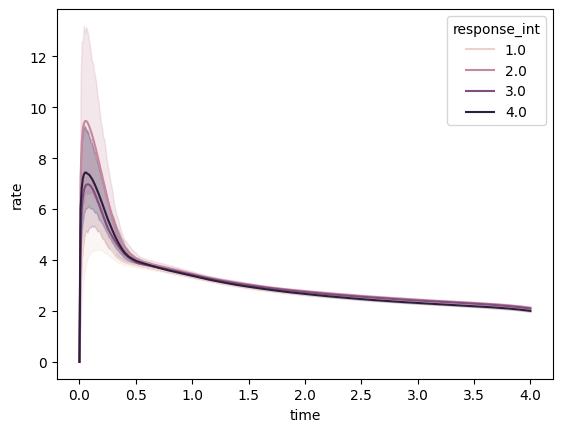

In [44]:
sns.lineplot(saccade_data.query("condition == 'equalIndifference'"), x = "time", y = "rate", hue = "response_int")

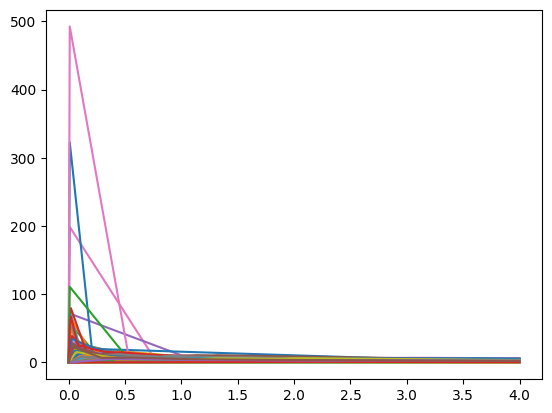

In [72]:
sub_df = saccade_data.query("sub == 3")
for trial in sub_df['trial'].unique():
    trial_df = sub_df.query("trial == @trial")
    plt.plot(trial_df['time'], trial_df['rate'])
plt.show()

<Axes: xlabel='time', ylabel='rate'>

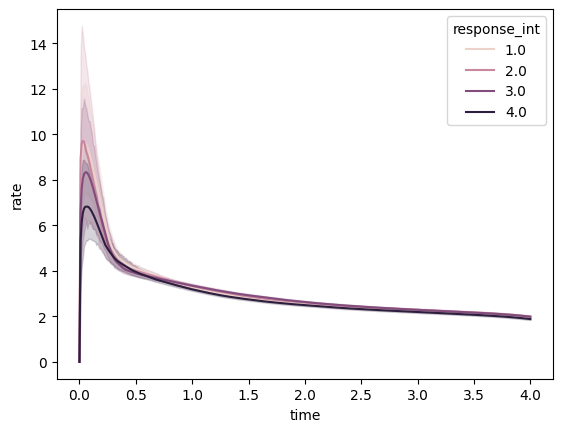

In [45]:
sns.lineplot(saccade_data.query("condition == 'equalRange'"), x = "time", y = "rate", hue = "response_int")

In [62]:
def function_(t, A, B, alpha = 1, beta = 0.5):
    return A * np.exp(-alpha*t) - B * np.exp(-beta*t) + B - A


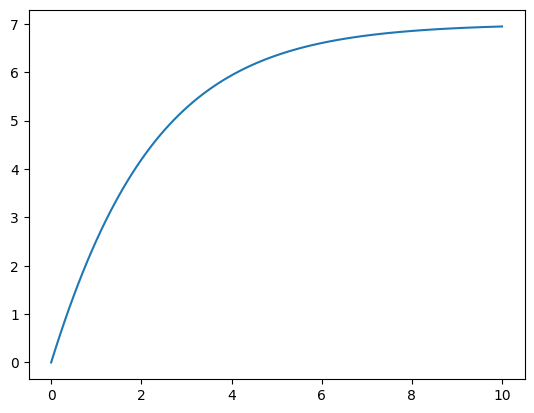

In [70]:
A = 1
B = 8
alpha = 0.9
beta = 1
t = np.linspace(0, 10, 100)
y = function_(t, A, B)

plt.plot(t, y)

In [47]:
%%R -i saccade_data
library(lme4)
library(lmerTest)
library(mgcv)

Loading required package: Matrix

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step

Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:lme4’:

    lmList

This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.


In [59]:
%%R
saccade_data$condition <- as.factor(saccade_data$condition)
saccade_data$response_int <- as.factor(saccade_data$response_int)

# GAM model for saccade rate through time
model <- gam(rate ~ s(time, k= 50), random = list(sub=~1), data = saccade_data, family = gaussian())

# decrease to 50Hz cause it takes so long to load and run the models...

In [60]:
%%R
summary(model)


Family: gaussian 
Link function: identity 

Formula:
rate ~ s(time, k = 50)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.040589   0.004088   743.7   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
          edf Ref.df    F p-value    
s(time) 48.68  48.99 1637  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.0187   Deviance explained = 1.87%
GCV = 70.352  Scale est. = 70.351    n = 4208896


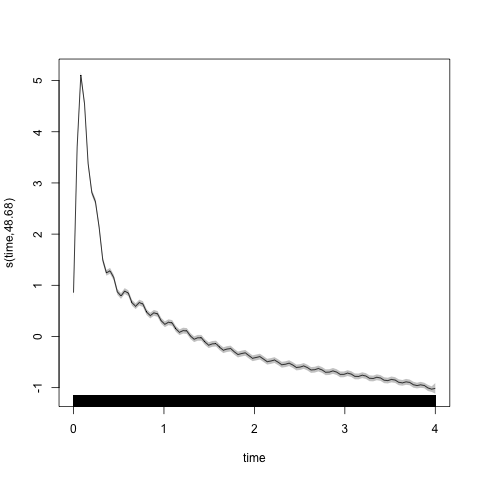

In [61]:
%%R
plot(model, select = 1, shade = TRUE, rug = TRUE)

### Lets see how blink rate changes based on prospect

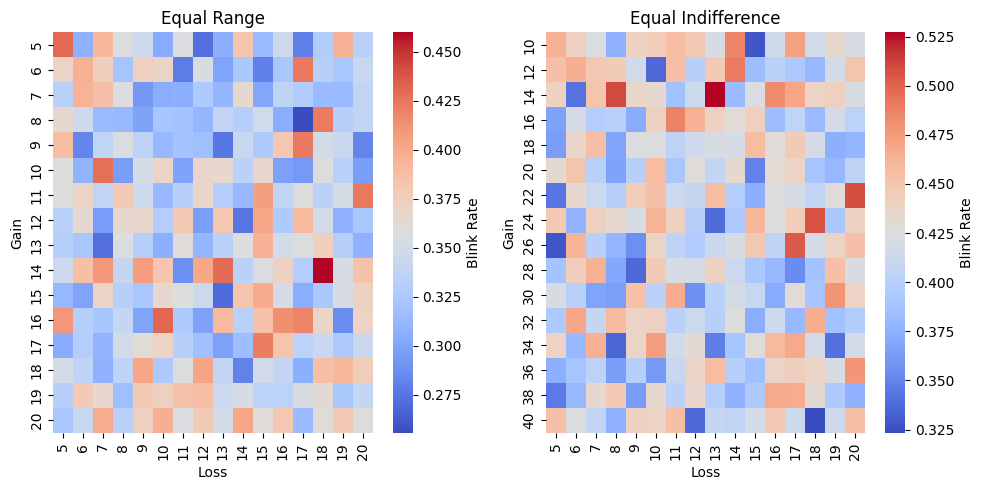

In [6]:
# Two figures: Blink rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = blink_data.query("condition == 'equalRange'").groupby(['gain', 'loss'])['blink_rate'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Blink Rate'}, ax = axs[0])
axs[0].set_title("Equal Range")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = blink_data.query("condition == 'equalIndifference'").groupby(['gain', 'loss'])['blink_rate'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Blink Rate'}, ax = axs[1])
axs[1].set_title("Equal Indifference")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

In [11]:
%%R -i blink_data
library(lme4)
library(lmerTest)
# Linear regression model for blink rate

# Model 1: response time ~ gain + loss + dist_indiff + gain:condition_num + loss:condition_num + dist_indiff:condition_num + (1|subj_ID)
model3 <- lmer(blink_rate ~ gain + loss + dist_indiff + gain:condition + loss:condition + dist_indiff:condition + (1|sub), data=blink_data)
summary(model3)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
blink_rate ~ gain + loss + dist_indiff + gain:condition + loss:condition +  
    dist_indiff:condition + (1 | sub)
   Data: blink_data

REML criterion at convergence: -7588.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.9150 -0.5632 -0.1316  0.5142 11.5899 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.05464  0.2338  
 Residual             0.03318  0.1821  
Number of obs: 14080, groups:  sub, 55

Fixed effects:
                                  Estimate Std. Error         df t value
(Intercept)                      3.789e-01  3.215e-02  5.798e+01  11.789
gain                             6.422e-05  7.240e-04  1.402e+04   0.089
loss                             1.914e-04  7.709e-04  1.407e+04   0.248
dist_indiff                     -9.782e-04  1.140e-03  1.403e+04  -0.858
gain:conditionequalRange         1.341e-03  8.647e-04  1.407e+04   1.5

### 

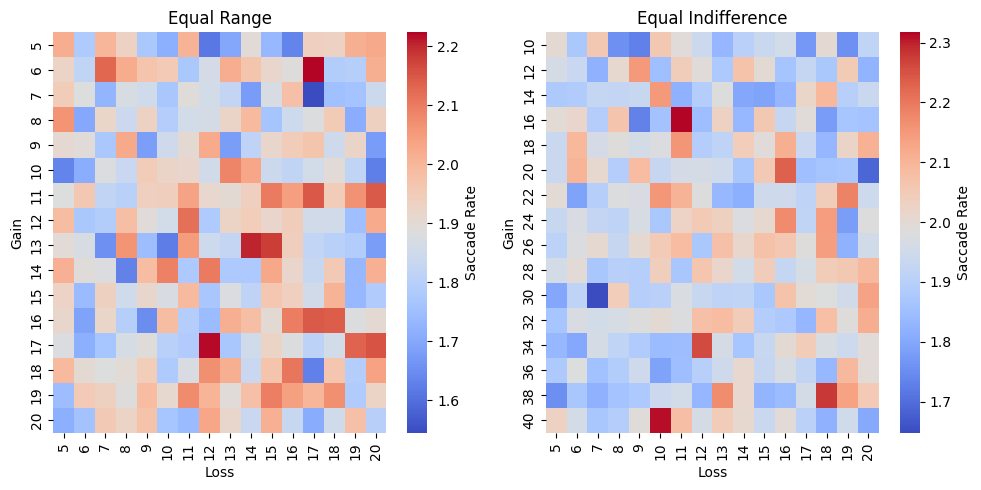

In [8]:
# Two figures: Sacc rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = saccade_data.query("condition == 'equalRange'").groupby(['gain', 'loss'])['sacc_rate'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Saccade Rate'}, ax = axs[0])
axs[0].set_title("Equal Range")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = saccade_data.query("condition == 'equalIndifference'").groupby(['gain', 'loss'])['sacc_rate'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Saccade Rate'}, ax = axs[1])
axs[1].set_title("Equal Indifference")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

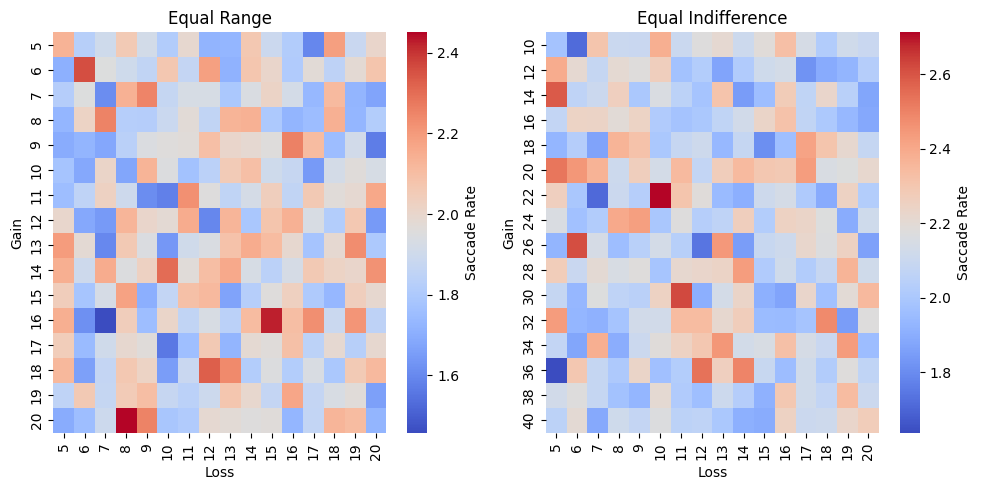

In [7]:
# Two figures: Mean ampl per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = saccade_data.query("condition == 'equalRange'").groupby(['gain', 'loss'])['mean_ampl'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Saccade Rate'}, ax = axs[0])
axs[0].set_title("Equal Range")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = saccade_data.query("condition == 'equalIndifference'").groupby(['gain', 'loss'])['mean_ampl'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Saccade Rate'}, ax = axs[1])
axs[1].set_title("Equal Indifference")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

In [12]:
%%R -i saccade_data
library(lme4)
library(lmerTest)
# Linear regression model for blink rate

# Model 1: response time ~ gain + loss + dist_indiff + gain:condition_num + loss:condition_num + dist_indiff:condition_num + (1|subj_ID)
model3 <- lmer(sacc_rate ~ gain + loss + dist_indiff + gain:condition + loss:condition + dist_indiff:condition + (1|sub), data=saccade_data)
summary(model3)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
sacc_rate ~ gain + loss + dist_indiff + gain:condition + loss:condition +  
    dist_indiff:condition + (1 | sub)
   Data: saccade_data

REML criterion at convergence: 23042.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.7505 -0.6032 -0.0184  0.5756  7.9805 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.2448   0.4947  
 Residual             0.2932   0.5415  
Number of obs: 14080, groups:  sub, 55

Fixed effects:
                                  Estimate Std. Error         df t value
(Intercept)                      1.885e+00  6.930e-02  6.225e+01  27.205
gain                             6.574e-03  2.153e-03  1.402e+04   3.054
loss                            -2.549e-03  2.286e-03  1.396e+04  -1.115
dist_indiff                     -9.844e-03  3.390e-03  1.404e+04  -2.904
gain:conditionequalRange        -4.104e-03  2.567e-03  1.406e+04  -1.

In [8]:
%%R -i saccade_data
library(lme4)
library(lmerTest)
# Linear regression model for blink rate

# Model 1: response time ~ gain + loss + dist_indiff + gain:condition_num + loss:condition_num + dist_indiff:condition_num + (1|subj_ID)
model3 <- lmer(mean_ampl ~ gain + loss + dist_indiff + gain:condition + loss:condition + dist_indiff:condition + (1|sub), data=saccade_data)
summary(model3)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
mean_ampl ~ gain + loss + dist_indiff + gain:condition + loss:condition +  
    dist_indiff:condition + (1 | sub)
   Data: saccade_data

REML criterion at convergence: 37455.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2311 -0.5610 -0.1738  0.3286 15.2596 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.3748   0.6122  
 Residual             0.8212   0.9062  
Number of obs: 14062, groups:  sub, 55

Fixed effects:
                                  Estimate Std. Error         df t value
(Intercept)                      2.030e+00  8.833e-02  6.894e+01  22.986
gain                             6.947e-03  3.602e-03  1.401e+04   1.929
loss                            -6.938e-03  3.813e-03  1.357e+04  -1.820
dist_indiff                     -1.105e-02  5.672e-03  1.403e+04  -1.948
gain:conditionequalRange        -4.835e-03  4.287e-03  1.393e+04  -1.

Loading required package: Matrix

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step

